In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

tps = pd.read_csv(
    "avg_HC3_all_pearson_corr_feats.csv", parse_dates=["time"]
)
print(tps.shape)
print(tps.columns)

(36000, 245)
Index(['Unnamed: 0', 'WRich05_S', 'WRich10_S', 'WRich15_S', 'WRich20_S',
       'WClar05_S', 'WClar10_S', 'WClar15_S', 'WClar20_S', 'WNois05_S',
       ...
       'rouge-1-p', 'rouge-1-r', 'rouge-1-f', 'rouge-2-p', 'rouge-2-r',
       'rouge-2-f', 'rouge-l-p', 'rouge-l-r', 'rouge-l-f', 'time'],
      dtype='object', length=245)


In [2]:
gps = tps.groupby("time").agg('mean').drop("Unnamed: 0", axis=1)
print(gps.shape)
print(gps.columns)

(36, 243)
Index(['WRich05_S', 'WRich10_S', 'WRich15_S', 'WRich20_S', 'WClar05_S',
       'WClar10_S', 'WClar15_S', 'WClar20_S', 'WNois05_S', 'WNois10_S',
       ...
       'ppl', 'rouge-1-p', 'rouge-1-r', 'rouge-1-f', 'rouge-2-p', 'rouge-2-r',
       'rouge-2-f', 'rouge-l-p', 'rouge-l-r', 'rouge-l-f'],
      dtype='object', length=243)


In [3]:
gps["rouge-l-p"].plot(figsize=(16, 6), fontsize=15)
plt.xlabel("Date")
plt.ylabel("rouge-l-p")


Text(0, 0.5, 'rouge-l-p')

Working with multiple time series presents certain challenges. One example, as we saw, is the different **scales** each distribution comes in:

In [4]:
drop_cols = gps.columns[3:230]
drop_df = gps.drop(drop_cols, axis=1)

drop_df.plot(figsize=(16, 6), fontsize=15)

plt.xlabel("Date")
plt.ylabel("Raw score")

Text(0, 0.5, 'Raw score')

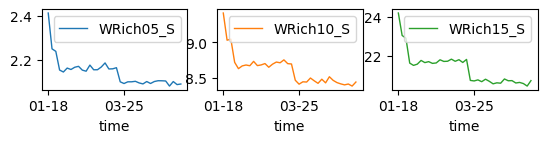

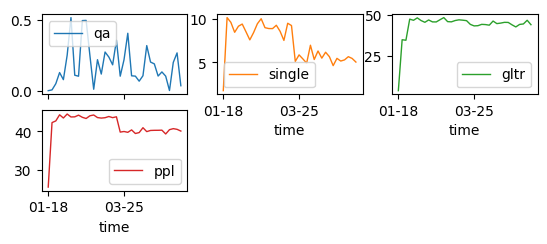

In [5]:
# linguistic feature
drop_df[gps.columns[:3]].plot(subplots=True, layout=(4, 3), linewidth=1)
# classify feature
drop_df[gps.columns[230:234]].plot(subplots=True, layout=(4, 3), linewidth=1)
# rouge score
v1_cols = ["rouge-2-r", "rouge-l-r", "rouge-2-p",
           "rouge-l-p", "rouge-2-f", "rouge-l-f"]
wrich_cols = ["WRich05_S", "rouge-l-r", "WRich10_S", "rouge-l-p", "WRich15_S", "rouge-l-f"]
plt.rcParams.update({'font.size': 13})
drop_df[wrich_cols].plot(subplots=True, layout=(3, 2), linewidth=1,legend=True)
plt.savefig("/home/tsq/Desktop/tsinghua23/CK/trend/rouge_v2.pdf", bbox_inches='tight')



## Solution: normalization
When normalizing time series, you divide every data point in the distribution by the first sample. This has the effect of representing every single data point as the percentage increase relative to the first sample:


In [6]:
normalized = drop_df.div(drop_df.iloc[0]).mul(100)  # Multiply by 100 to get percentages

normalized.plot(figsize=(16, 8),
                title="Growth of Different Scores")
plt.xlabel("Date")
plt.ylabel("Increase (%)");



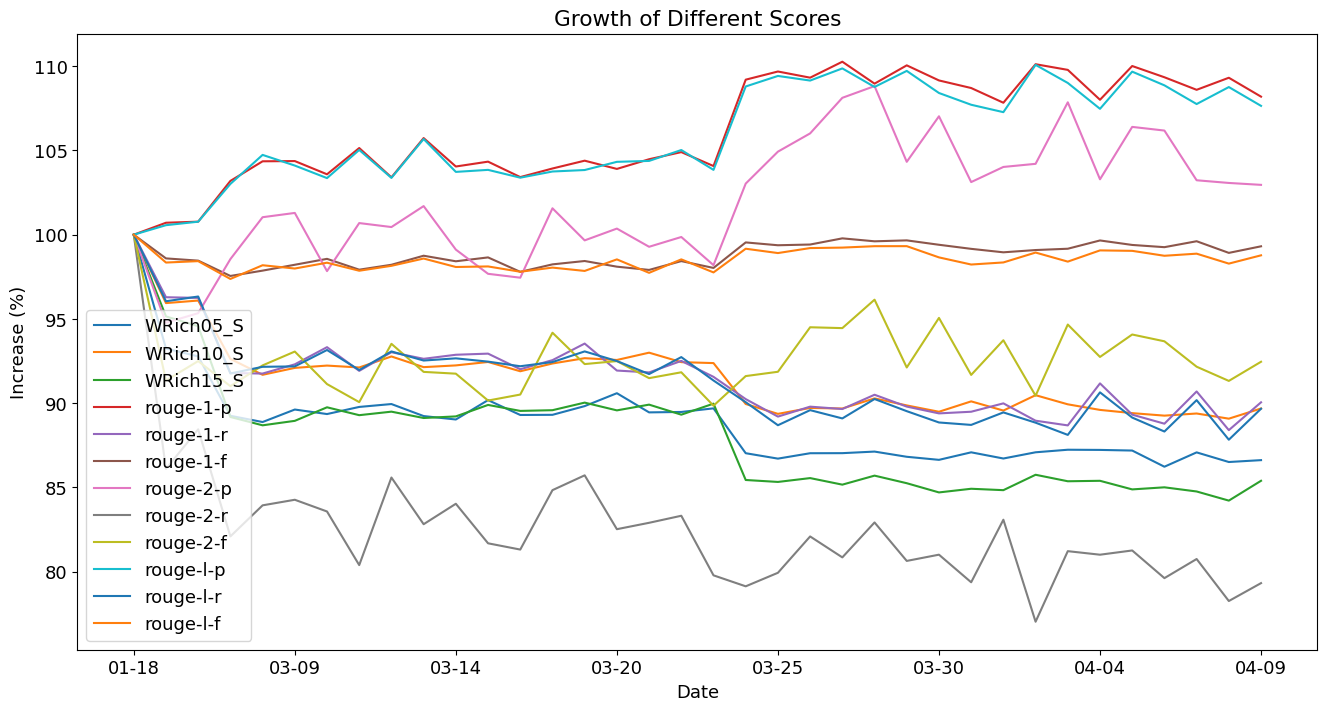

In [7]:
new_drop_df = drop_df.drop(["qa", "gltr", "ppl", "single"], axis=1)
new_normalized = new_drop_df.div(new_drop_df.iloc[0]).mul(100)  # Multiply by 100 to get percentages

new_normalized.plot(figsize=(16, 8),
                    title="Growth of Different Scores")
plt.xlabel("Date")
plt.ylabel("Increase (%)");


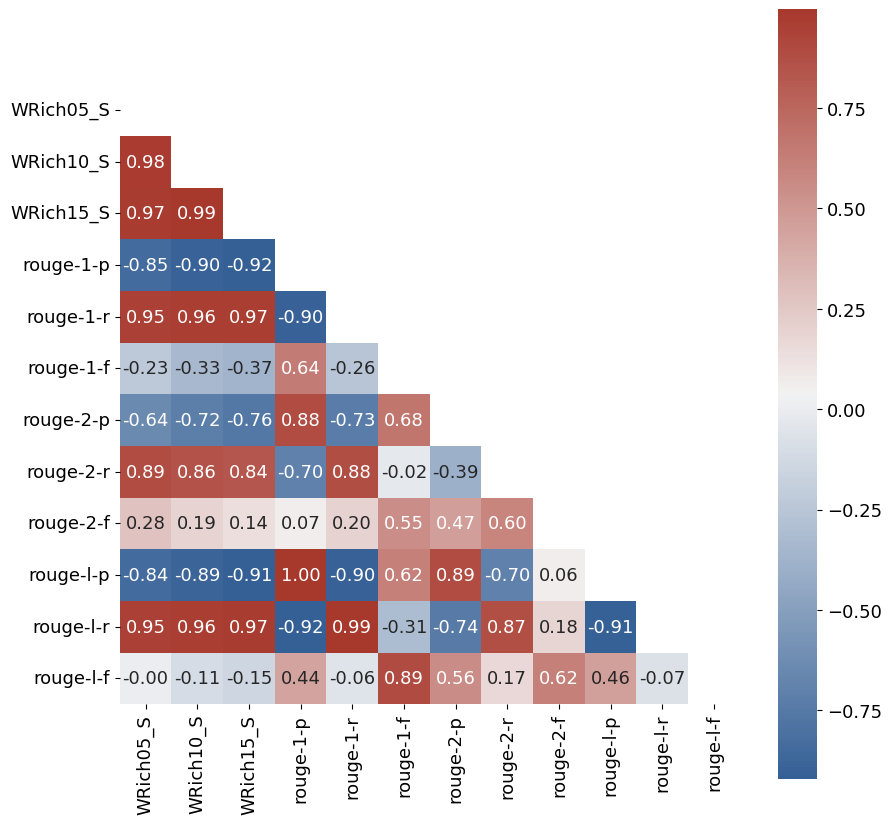

           WRich05_S  WRich10_S  WRich15_S  rouge-1-p  rouge-1-r  rouge-1-f  \
WRich05_S   1.000000   0.978765   0.971837  -0.846429   0.949342  -0.226949   
WRich10_S   0.978765   1.000000   0.992027  -0.897522   0.960024  -0.332395   
WRich15_S   0.971837   0.992027   1.000000  -0.921779   0.965486  -0.373736   
rouge-1-p  -0.846429  -0.897522  -0.921779   1.000000  -0.899631   0.636618   
rouge-1-r   0.949342   0.960024   0.965486  -0.899631   1.000000  -0.261577   
rouge-1-f  -0.226949  -0.332395  -0.373736   0.636618  -0.261577   1.000000   
rouge-2-p  -0.643057  -0.719078  -0.757125   0.884143  -0.730442   0.680275   
rouge-2-r   0.886866   0.856525   0.835687  -0.704027   0.880854  -0.024099   
rouge-2-f   0.283030   0.190487   0.139872   0.066510   0.201619   0.549070   
rouge-l-p  -0.841313  -0.891109  -0.914298   0.995988  -0.900295   0.617853   
rouge-l-r   0.949352   0.963419   0.970435  -0.915886   0.994523  -0.314617   
rouge-l-f  -0.000342  -0.107885  -0.145990   0.44052

In [8]:
# Create a custom palette
# cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)
# Compute corr matrix
matrix = new_drop_df.corr(method="pearson")
# Create a mask
mask = np.triu(np.ones_like(matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(matrix, mask=mask, square=True, cmap=cmap, annot=True, fmt=".2f", ax=ax)
plt.show()
print(matrix)

Use normalized matrix will get the same correlation:
$r = \frac{\sum_{i=1}^n(x_i -\bar{x})(y_i -\bar{y})}{\sqrt{\sum_{i=1}^n(x_i -\bar{x})^2 }\sqrt{\sum_{i=1}^n(y_i -\bar{y})^2}}$

In [9]:
new_normalized1 = new_normalized.drop(["rouge-1-r", "rouge-1-p", "rouge-1-f",
                                       "rouge-2-r", "rouge-2-p", "rouge-2-f"], axis=1)
norm_matrix = new_normalized1.corr(method="pearson")
print(norm_matrix)
# Create a mask
mask = np.triu(np.ones_like(norm_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(norm_matrix, square=True, cmap="YlGnBu", annot=True, fmt=".2f", ax=ax)
plt.savefig("/home/tsq/Desktop/tsinghua23/CK/temporal/heat_map_v1.pdf", bbox_inches='tight')
plt.show()

           WRich05_S  WRich10_S  WRich15_S  rouge-l-p  rouge-l-r  rouge-l-f
WRich05_S   1.000000   0.978765   0.971837  -0.841313   0.949352  -0.000342
WRich10_S   0.978765   1.000000   0.992027  -0.891109   0.963419  -0.107885
WRich15_S   0.971837   0.992027   1.000000  -0.914298   0.970435  -0.145990
rouge-l-p  -0.841313  -0.891109  -0.914298   1.000000  -0.908666   0.457150
rouge-l-r   0.949352   0.963419   0.970435  -0.908666   1.000000  -0.072736
rouge-l-f  -0.000342  -0.107885  -0.145990   0.457150  -0.072736   1.000000


/home/tsq/anaconda3/envs/basketball_predict/lib/python3.8/site-packages/seaborn/matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


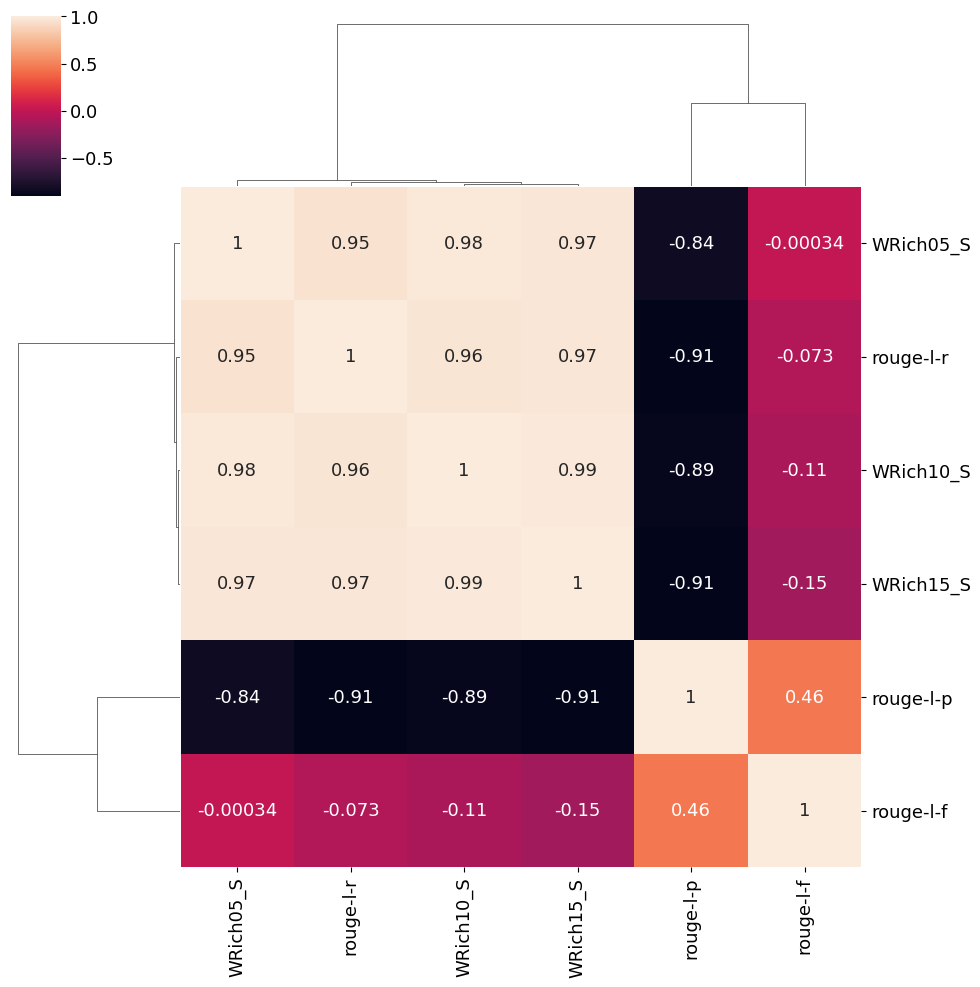

In [10]:
sns.clustermap(norm_matrix, annot=True, square=True)
plt.savefig("/home/tsq/Desktop/tsinghua23/CK/temporal/clustermap_v1.pdf", bbox_inches='tight')
plt.show()

## autocorrelation function plot
The XAxis of an autocorrelation function plot (ACF) is the lag number k. For example, when k=1, the correlation is found by shifting the series by 1. This is the same as using the shift function of Pandas:

The YAXis is the amount of correlation at each lag k. The shaded red region is a confidence interval â€” if the height of the bars is outside this region, it means the correlation is statistically significant.

Please pause and think of what you can learn from an ACF plot.

They offer an alternative way of detecting patterns and seasonality. For example, the ACF plot of temperature in Celcius shows that the correlation at every 15 lags decreases or every 25 lags increases.

When a clear trend exists in a time series, the autocorrelation tends to be high at small lags like 1 or 2. When seasonality exists, the autocorrelation goes up periodically at larger lags.

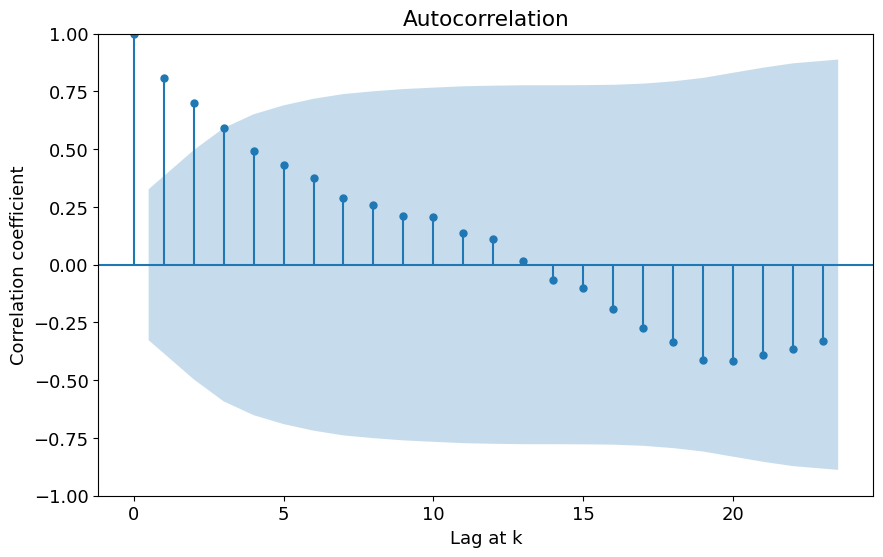

In [11]:
from matplotlib import rcParams
from statsmodels.graphics import tsaplots

rcParams["figure.figsize"] = 10, 6

# Stands for Time Series Analysis Plots (TSA Plots)
fig = tsaplots.plot_acf(gps["rouge-l-p"], lags=23)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

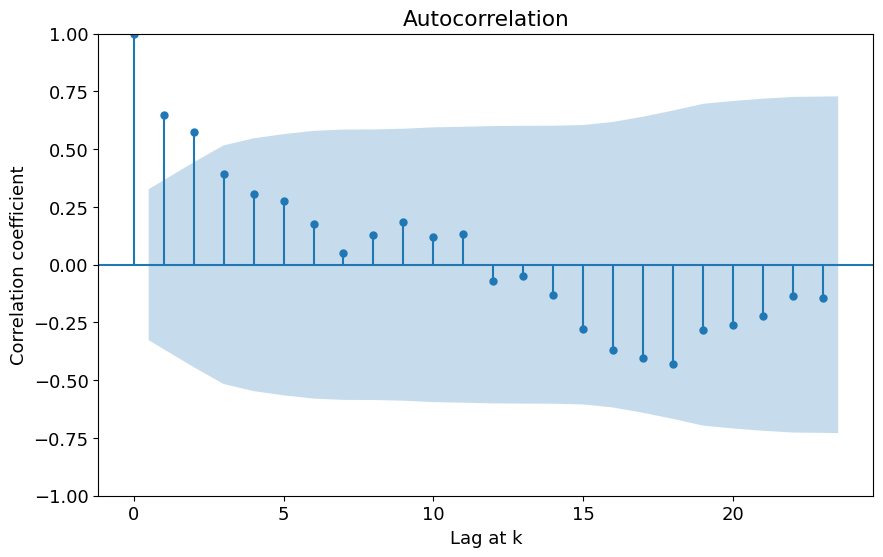

In [12]:
fig = tsaplots.plot_acf(gps["rouge-1-f"], lags=23)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()


In [13]:
# Mind the extra 'p' in plot_pacf
# fig = tsaplots.plot_pacf(gps["rouge-1-f"], lags=23)
#
# plt.title("Partial Autocorrelation of rouge-1-f")
# plt.xlabel("Lag at k")
# plt.ylabel("Correlation Coefficient")
# plt.show();

Index(['BTopc15_S', 'BTopc20_S', 'to_EntiM_C', 'as_EntiM_C', 'at_EntiM_C',
       'to_UEnti_C', 'as_UEnti_C', 'at_UEnti_C', 'ra_SNTo_C', 'ra_ONTo_C',
       'ra_XNTo_C', 'ra_NSTo_C', 'ra_NOTo_C', 'ra_NXTo_C', 'ra_NNTo_C',
       'LoCohPA_S', 'LoCohPW_S', 'LoCohPU_S', 'LoCoDPA_S', 'LoCoDPW_S',
       'LoCoDPU_S', 'to_NoPhr_C', 'as_NoPhr_C', 'at_NoPhr_C'],
      dtype='object')


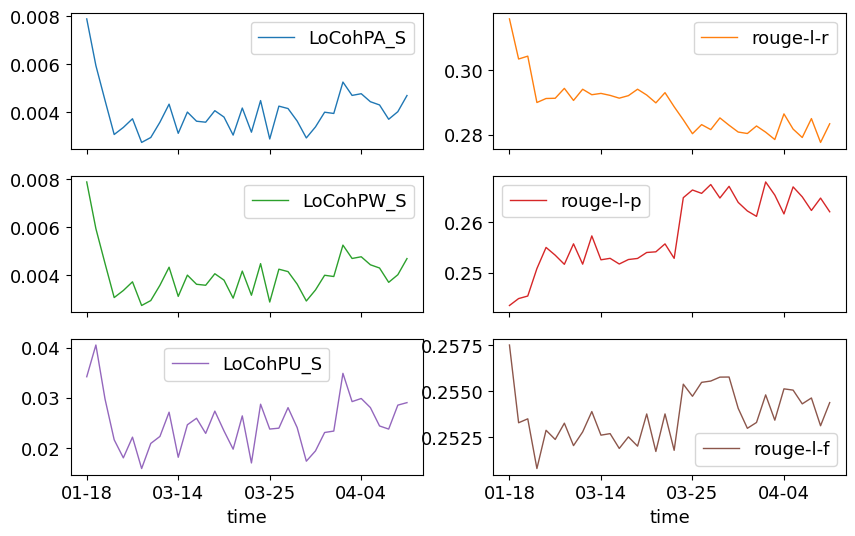

In [39]:
# Disco linguistic rouge score
wrich_cols = ['LoCohPA_S',  "rouge-l-r", 'LoCohPW_S', "rouge-l-p",'LoCohPU_S',"rouge-l-f"]
plt.rcParams.update({'font.size': 13})
print(gps.columns[30:54])
gps[wrich_cols].plot(subplots=True, layout=(3, 2), linewidth=1,legend=True)
plt.savefig("/home/tsq/Desktop/tsinghua23/CK/ling_trend/Disco_rouge_v1.pdf", bbox_inches='tight')


Index(['BRich10_S', 'BRich15_S', 'BRich20_S', 'BClar05_S', 'BClar10_S',
       'BClar15_S', 'BClar20_S', 'BNois05_S', 'BNois10_S', 'BNois15_S',
       'BNois20_S', 'BTopc05_S', 'BTopc10_S', 'BTopc15_S', 'BTopc20_S'],
      dtype='object')


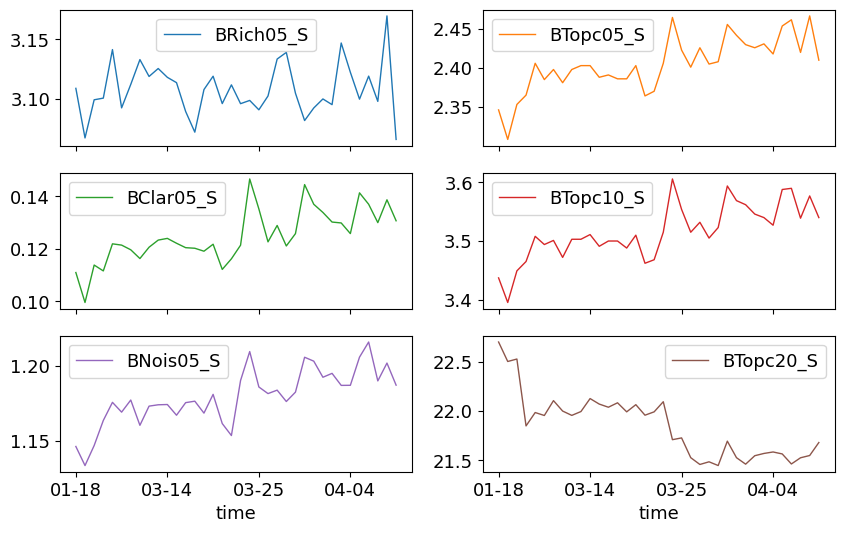

In [44]:
# AdSem linguistic rouge score
wrich_cols = ['BRich05_S',  "BTopc05_S", 'BClar05_S', "BTopc10_S",'BNois05_S',"BTopc20_S"]
plt.rcParams.update({'font.size': 13})
print(gps.columns[17:32])
gps[wrich_cols].plot(subplots=True, layout=(3, 2), linewidth=1,legend=True)
plt.savefig("/home/tsq/Desktop/tsinghua23/CK/ling_trend/Adsem_v1.pdf", bbox_inches='tight')


Index(['BTopc15_S', 'BTopc20_S', 'to_EntiM_C', 'as_EntiM_C', 'at_EntiM_C',
       'to_UEnti_C', 'as_UEnti_C', 'at_UEnti_C', 'ra_SNTo_C', 'ra_ONTo_C',
       'ra_XNTo_C', 'ra_NSTo_C', 'ra_NOTo_C', 'ra_NXTo_C', 'ra_NNTo_C',
       'LoCohPA_S', 'LoCohPW_S', 'LoCohPU_S', 'LoCoDPA_S', 'LoCoDPW_S',
       'LoCoDPU_S', 'to_NoPhr_C', 'as_NoPhr_C', 'at_NoPhr_C'],
      dtype='object')


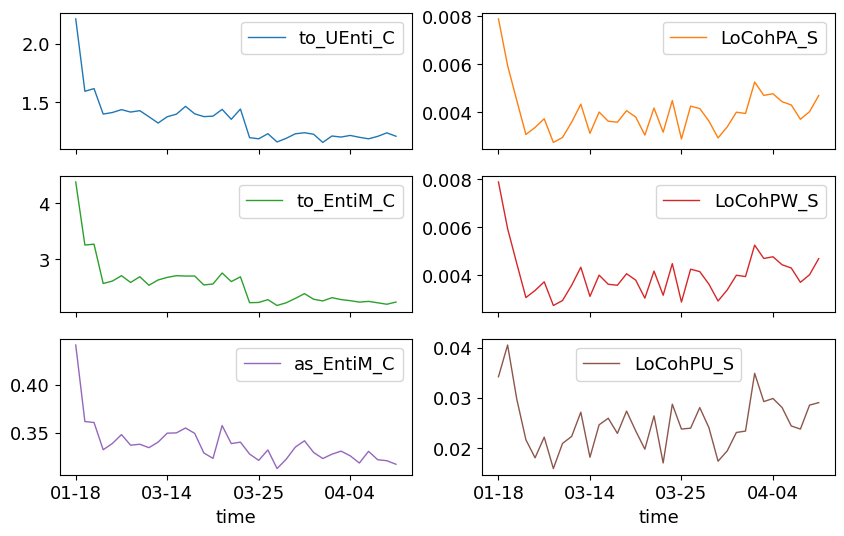

In [41]:
# Disco linguistic rouge score
wrich_cols = ['to_UEnti_C',  "LoCohPA_S", 'to_EntiM_C', "LoCohPW_S",'as_EntiM_C',"LoCohPU_S"]
plt.rcParams.update({'font.size': 13})
print(gps.columns[30:54])
gps[wrich_cols].plot(subplots=True, layout=(3, 2), linewidth=1,legend=True)
plt.savefig("/home/tsq/Desktop/tsinghua23/CK/ling_trend/Disco_v1.pdf", bbox_inches='tight')


In [49]:
# Synta linguistic rouge score
wrich_cols = ['to_FTree_C',  "to_NoTag_C", 'as_FTree_C', "as_NoTag_C",'at_FTree_C',"at_NoTag_C"]
plt.rcParams.update({'font.size': 13})
print(gps.columns[56:164])
gps[wrich_cols].plot(subplots=True, layout=(3, 2), linewidth=1,legend=True)
plt.savefig("/home/tsq/Desktop/tsinghua23/CK/ling_trend/Synta_v1.pdf", bbox_inches='tight')

Index(['ra_NoPrP_C', 'ra_NoAjP_C', 'ra_NoAvP_C', 'to_VePhr_C', 'as_VePhr_C',
       'at_VePhr_C', 'ra_VeNoP_C', 'ra_VeSuP_C', 'ra_VePrP_C', 'ra_VeAjP_C',
       ...
       'as_ContW_C', 'at_ContW_C', 'to_FuncW_C', 'as_FuncW_C', 'at_FuncW_C',
       'ra_CoFuW_C', 'SimpTTR_S', 'CorrTTR_S', 'BiLoTTR_S', 'UberTTR_S'],
      dtype='object', length=108)


In [54]:
# LxSem linguistic rouge score
wrich_cols = ['SimpNoV_S',  "SimpTTR_S", 'SquaNoV_S', "CorrTTR_S",'CorrNoV_S',"BiLoTTR_S"]
plt.rcParams.update({'font.size': 13})
print(gps.columns[164:214])
gps[wrich_cols].plot(subplots=True, layout=(3, 2), linewidth=1,legend=True)
plt.savefig("/home/tsq/Desktop/tsinghua23/CK/ling_trend/LxSem_v1.pdf", bbox_inches='tight')

Index(['MTLDTTR_S', 'SimpNoV_S', 'SquaNoV_S', 'CorrNoV_S', 'SimpVeV_S',
       'SquaVeV_S', 'CorrVeV_S', 'SimpAjV_S', 'SquaAjV_S', 'CorrAjV_S',
       'SimpAvV_S', 'SquaAvV_S', 'CorrAvV_S', 'to_AAKuW_C', 'as_AAKuW_C',
       'at_AAKuW_C', 'to_AAKuL_C', 'as_AAKuL_C', 'at_AAKuL_C', 'to_AABiL_C',
       'as_AABiL_C', 'at_AABiL_C', 'to_AABrL_C', 'as_AABrL_C', 'at_AABrL_C',
       'to_AACoL_C', 'as_AACoL_C', 'at_AACoL_C', 'to_SbFrQ_C', 'as_SbFrQ_C',
       'at_SbFrQ_C', 'to_SbCDC_C', 'as_SbCDC_C', 'at_SbCDC_C', 'to_SbFrL_C',
       'as_SbFrL_C', 'at_SbFrL_C', 'to_SbCDL_C', 'as_SbCDL_C', 'at_SbCDL_C',
       'to_SbSBW_C', 'as_SbSBW_C', 'at_SbSBW_C', 'to_SbL1W_C', 'as_SbL1W_C',
       'at_SbL1W_C', 'to_SbSBC_C', 'as_SbSBC_C', 'at_SbSBC_C', 'to_SbL1C_C'],
      dtype='object')


In [56]:
# LxSem linguistic rouge score
wrich_cols = [ "to_AAKuW_C", 'to_SbFrQ_C',  "as_AAKuW_C",'as_SbFrQ_C',"at_AAKuW_C",'at_SbFrQ_C',]
plt.rcParams.update({'font.size': 13})
print(gps.columns[164:214])
gps[wrich_cols].plot(subplots=True, layout=(3, 2), linewidth=1,legend=True)
plt.savefig("/home/tsq/Desktop/tsinghua23/CK/ling_trend/LxSem_v2.pdf", bbox_inches='tight')


Index(['MTLDTTR_S', 'SimpNoV_S', 'SquaNoV_S', 'CorrNoV_S', 'SimpVeV_S',
       'SquaVeV_S', 'CorrVeV_S', 'SimpAjV_S', 'SquaAjV_S', 'CorrAjV_S',
       'SimpAvV_S', 'SquaAvV_S', 'CorrAvV_S', 'to_AAKuW_C', 'as_AAKuW_C',
       'at_AAKuW_C', 'to_AAKuL_C', 'as_AAKuL_C', 'at_AAKuL_C', 'to_AABiL_C',
       'as_AABiL_C', 'at_AABiL_C', 'to_AABrL_C', 'as_AABrL_C', 'at_AABrL_C',
       'to_AACoL_C', 'as_AACoL_C', 'at_AACoL_C', 'to_SbFrQ_C', 'as_SbFrQ_C',
       'at_SbFrQ_C', 'to_SbCDC_C', 'as_SbCDC_C', 'at_SbCDC_C', 'to_SbFrL_C',
       'as_SbFrL_C', 'at_SbFrL_C', 'to_SbCDL_C', 'as_SbCDL_C', 'at_SbCDL_C',
       'to_SbSBW_C', 'as_SbSBW_C', 'at_SbSBW_C', 'to_SbL1W_C', 'as_SbL1W_C',
       'at_SbL1W_C', 'to_SbSBC_C', 'as_SbSBC_C', 'at_SbSBC_C', 'to_SbL1C_C'],
      dtype='object')


Index(['as_SbL1C_C', 'at_SbL1C_C', 'TokSenM_S', 'TokSenS_S', 'TokSenL_S',
       'as_Token_C', 'as_Sylla_C', 'at_Sylla_C', 'as_Chara_C', 'at_Chara_C',
       'FleschG_S', 'AutoRea_S', 'ColeLia_S', 'SmogInd_S', 'Gunning_S',
       'LinseaW_S', 'qa', 'single', 'gltr', 'ppl', 'rouge-1-p', 'rouge-1-r',
       'rouge-1-f', 'rouge-2-p', 'rouge-2-r', 'rouge-2-f', 'rouge-l-p',
       'rouge-l-r', 'rouge-l-f'],
      dtype='object')


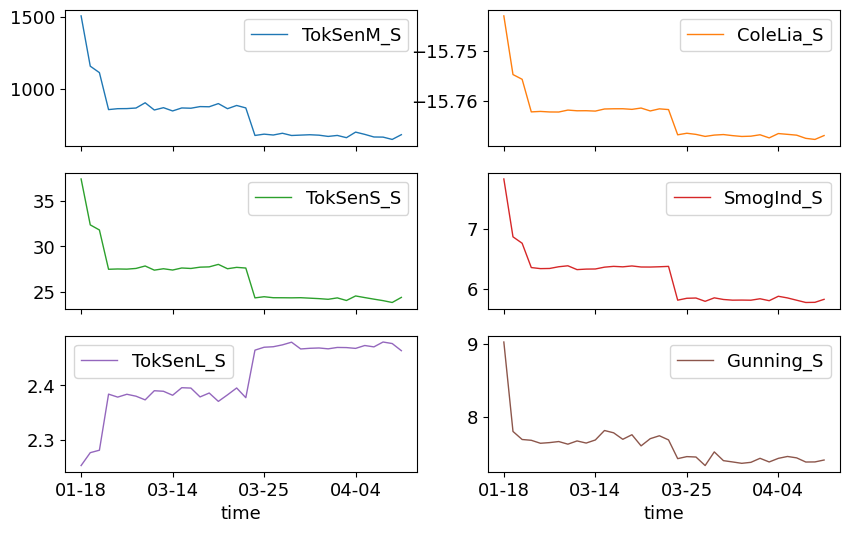

In [53]:
# ShaF linguistic rouge score
wrich_cols = ['TokSenM_S',  "ColeLia_S", 'TokSenS_S', "SmogInd_S",'TokSenL_S',"Gunning_S"]
plt.rcParams.update({'font.size': 13})
print(gps.columns[214:])
gps[wrich_cols].plot(subplots=True, layout=(3, 2), linewidth=1,legend=True)
plt.savefig("/home/tsq/Desktop/tsinghua23/CK/ling_trend/ShaF_v1.pdf", bbox_inches='tight')